# Setup

In [39]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import time

# Helper functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Pipeline

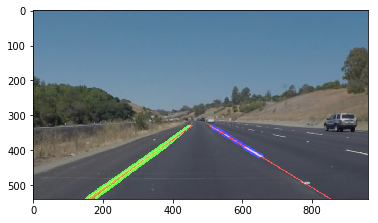

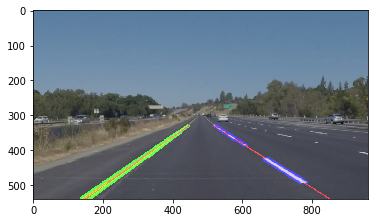

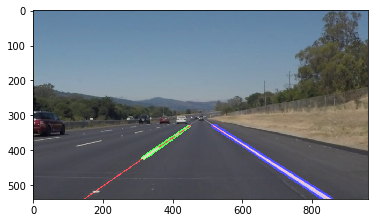

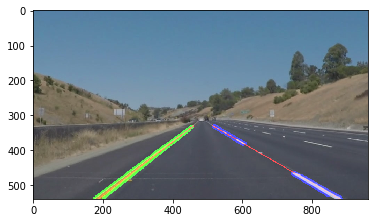

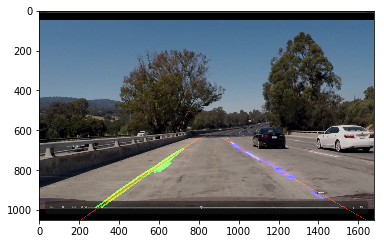

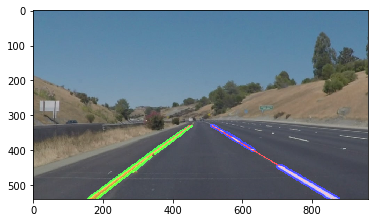

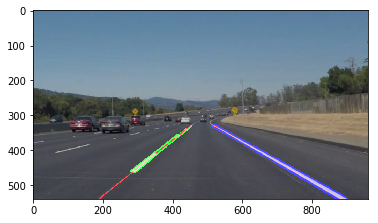

In [267]:
# from sklearn import linear_model
import math

# Lane-finding pipeline constants

REF_WIDTH = 960.0
REF_HEIGHT = 540.0

# Color score filtering
YELLOW_HUE = 100
YELLOW_VALUE = 140
YELLOW_MAX = 90*90*255*YELLOW_VALUE
WHITE_MAX = 255*255*255
BACKGROUND_WINDOW = 30/REF_WIDTH # Radius of rectangular window for background lighting

# Edge detection
GAUSSIAN_KERNEL_SIZE = 5
CANNY_LOW_THRESHOLD = 40
CANNY_HIGH_THRESHOLD = 120

# Region of interest
MAX_HEIGHT = 330/REF_HEIGHT
X_MIN_BOTTOM = 100/REF_WIDTH
X_MAX_BOTTOM = 940/REF_WIDTH
X_MIN_TOP = 420/REF_WIDTH
X_MAX_TOP = 570/REF_WIDTH

# Line finding
PIXEL_RESOLUTION = 2/REF_WIDTH
ANGULAR_RESOLUTION = 2*math.pi/180
LINE_THRESHOLD = 30
MIN_LINE_LENGTH = 30/REF_WIDTH
MAX_LINE_GAP = 40/REF_WIDTH

# Line filtering
MIN_SLOPE = 0.5
MAX_SLOPE = 1/MIN_SLOPE


def background_lighting(img):
    # Compute the integral of img
    simg = np.cumsum(np.cumsum(img.astype(np.int64), 0), 1)
    
    # Construct window-bounding integral indices for each pixel
    i_x, i_y = np.meshgrid(range(0,img.shape[1]), range(0,img.shape[0]))
    r = int(BACKGROUND_WINDOW*img.shape[1])
    i0_x = np.maximum(i_x - r, 0)
    i0_y = np.maximum(i_y - r, 0)
    i1_x = np.minimum(i_x + r, img.shape[1]-1)
    i1_y = np.minimum(i_y + r, img.shape[0]-1)
    
    # Sum in window starts as the integral from (0,0) to the lower-right window pixel
    bg = simg[i1_y, i1_x]
    mask = i0_x > 0
    
    # ...but subtract the integral from (0,0) to the lower-left window pixel
    bg[mask] -= simg[i1_y, i0_x-1][mask]
    mask = i0_y > 0
    
    # ...and also subtract the integral from (0,0) to the upper-right window pixel
    bg[mask] -= simg[i0_y-1, i1_x][mask]
    
    # ...but then add back in the integral from (0,0) to the upper-left window pixel
    mask = np.logical_and(i0_x > 0, i0_y > 0)
    bg[mask] += simg[i0_y-1, i0_x-1][mask]
    
    # Divide sums-in-windows by actual window sizes
    area = (i1_y-i0_y+1) * (i1_x-i0_x+1)
    bg //= area
    
    return bg


def yellow_score(rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
    dH = np.abs(hsv[:,:,0].astype(np.int64) - YELLOW_HUE)
    dH[dH > 90] = 180 - dH[dH > 90]
    dH = 90 - dH
    return dH * dH * hsv[:,:,1].astype(np.int64) * np.minimum(hsv[:,:,2], YELLOW_VALUE).astype(np.int64)


def white_score(rgb):
    return rgb[:,:,0].astype(np.int64) * rgb[:,:,1].astype(np.int64) * rgb[:,:,2].astype(np.int64)


def normalize_image(img):
    vmin = img.min()
    vmax = img.max()
    return ((255 * (img - vmin)) / (vmax - vmin)).astype(np.uint8)
    
    
def linear_regression(x, y, w):
    """
    Perform linear regression on the provided points and return a function that
    computes x as a function of y
    """
    if len(x) < 2:
        return None
    
    # Convert raw lists into appropriate NumPy arrays
    if not type(x).__module__ == np.__name__:
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)
        w = np.array(w)
    
    # Fit the data points
    regr = linear_model.LinearRegression()
    regr.fit(x, y, w)
    
    # Evaluate error
    yp = regr.predict(x)
    sigma = np.std(yp - y)
    
    # Find an error threshold that all points should reasonably fall below
    # Kind of like this, but with 95% starting point: https://math.stackexchange.com/a/510580
    max_error = sigma * (1.645 + math.sqrt(2*math.log(len(x))))
    
    inlier_mask = np.abs(yp - y) <= max_error
    if np.sum(inlier_mask) == len(x):
        # If there aren't any outliers, then use this fit
        m = regr.coef_
        b = regr.intercept_
        def compute_x(yi):
            return (yi - b) / m
        return compute_x
    else:
        # If there are outliers, remove them and try again
        return linear_regression(
            x[inlier_mask].reshape(1, -1),
            y[inlier_mask].reshape(1, -1),
            w[inlier_mask.flatten()])

def draw_lane_lines(img, lines, left_color=[0, 255, 0], right_color=[0, 0, 255], thickness=5):
    if lines is None:
        return
    
    # For each line segment, classify it as part of the left or right lane line
    # and then add its end points to the list of points that make up that line
    x_left = []
    y_left = []
    w_left = []
    x_right = []
    y_right = []
    w_right = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            comx = (x1+x2)/2
            if m >= MIN_SLOPE and m <= MAX_SLOPE and comx > img.shape[1]/2:
                w = math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))
                x_right.extend([x1, x2])
                y_right.extend([y1, y2])
                w_right.extend([w, w])
                cv2.line(img, (x1,y1), (x2,y2), right_color, 10)
            elif m >= -MAX_SLOPE and m <= -MIN_SLOPE and comx < img.shape[1]/2:
                w = math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))
                x_left.extend([x1, x2])
                y_left.extend([y1, y2])
                w_left.extend([w, w])
                cv2.line(img, (x1,y1), (x2,y2), left_color, thickness)
    
    y1 = MAX_HEIGHT*img.shape[0]
    y2 = img.shape[0]
    
    # Regress and draw the left lane line
    fx = linear_regression(x_left, y_left, w_left)
    if fx is not None:
        cv2.line(img, (int(fx(y1)), int(y1)), (int(fx(y2)), int(y2)), [255,0,0], 2)
    
    # Regress and draw the right lane line
    fx = linear_regression(x_right, y_right, w_right)
    if fx is not None:
        cv2.line(img, (int(fx(y1)), int(y1)), (int(fx(y2)), int(y2)), [255,0,0], 2)


# Define new hough lines function to use draw_lane_lines above
def hough_lane_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lane lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lane_lines(line_img, lines)
    return line_img


def lanefind_pipeline(img):
    # Convert to grayscale corresponding to lane line content score (white or yellow)
    img_yellow = np.minimum(yellow_score(img) * 255 / YELLOW_MAX, 255).astype(np.uint8)
    img_white = np.minimum(white_score(img) * 255 / WHITE_MAX, 255).astype(np.uint8)
    gray = np.maximum(img_yellow, img_white)
        
    # Remove background lighting (brings out local contrast detail)
    bg = background_lighting(gray)
    fg = gray.astype(np.int64) - bg
    
    # Mask out for only the edges in the place we expect lane lines to be
    outline = np.array([
        [X_MIN_BOTTOM*img.shape[1], img.shape[0]],
        [X_MAX_BOTTOM*img.shape[1], img.shape[0]],
        [X_MAX_TOP*img.shape[1], MAX_HEIGHT*img.shape[0]],
        [X_MIN_TOP*img.shape[1], MAX_HEIGHT*img.shape[0]]], dtype=np.int32)
    mask = region_of_interest(np.ones(fg.shape, dtype=np.uint8), [outline]) > 0
    fg_min = fg[mask].min()
    fg_max = fg[mask].max()
    fg = ((fg - fg_min) * 255 / (fg_max - fg_min)).astype(np.uint8)
    
    # Identify sufficiently strong edges in the image
    edges = canny(gaussian_blur(fg, GAUSSIAN_KERNEL_SIZE),
                  CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    
    # Mask out for only the edges in the place we expect lane lines to be
    outline = np.array([
        [X_MIN_BOTTOM*edges.shape[1], img.shape[0]],
        [X_MAX_BOTTOM*edges.shape[1], img.shape[0]],
        [X_MAX_TOP*edges.shape[1], MAX_HEIGHT*img.shape[0]],
        [X_MIN_TOP*edges.shape[1], MAX_HEIGHT*img.shape[0]]], dtype=np.int32)
    edges = region_of_interest(edges, [outline])
    
    # Find lines
    lines = hough_lane_lines(edges,
                PIXEL_RESOLUTION*edges.shape[1], ANGULAR_RESOLUTION,
                LINE_THRESHOLD, MIN_LINE_LENGTH*edges.shape[1], MAX_LINE_GAP*edges.shape[1])
    
    return weighted_img(lines, img)

# Operate on the test images
for img_file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + img_file)
    processed_img = lanefind_pipeline(img)
    mpimg.imsave("test_images_output/" + img_file, processed_img, format='jpeg')
    plt.figure()
    plt.imshow(processed_img)
    

# Video setup

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lanefind_pipeline(image)

    return result

# Basic videos

## White

In [269]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:30<00:00,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 30.6 s, sys: 204 ms, total: 30.8 s
Wall time: 31.7 s


## Yellow

In [270]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:36<00:00,  7.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 35s, sys: 888 ms, total: 1min 36s
Wall time: 1min 37s


# Challenge

In [271]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4') #.subclip(4, 6)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [01:05<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min, sys: 3.8 s, total: 1min 4s
Wall time: 1min 7s


In [266]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))